# Graphical Models

Graphical models are graphical representations of conditional depencies between random variables. By merging together *probability theory* and *graph theory*, they provide a direct and compact way to visualize the structure of a model, to motivate the design of new models and to structure complex probability calculations for performing efficient inference. 

We usually distinguish between two types of graphical models:
- **Bayesian Networks** are ideal for modelling *conditional dependencies* between variables and are represented by *directed graphs*;
- **Markov Random Fields** are suitable for modelling *correlations*. In this case the underlying graph is *undirected*.

## Bayesian Networks

A Bayesian networks are Directed Acyclic Graphs (DAG) whose **nodes** represent variables in a Bayesian sense and whose **edges** represent conditional dependencies between variables.

The joint distribution defined by a directed graph is the product, over all the nodes of the graph, of the conditional distributions over the **parent nodes**

$$p(x)=\prod_{k=1}^K p(x_k|\text{parent}_k).$$

Two nodes $A$ and $B$ in a directed graph are **conditionally independent** given a node $C$  if and only if $$p(A,B|C)=p(A|C)p(B|C).$$

This condition is denoted by $A\perp \!\!\! \perp B|C$.

### DAG example

The survey dataset contains informations about usage of different transportation systems, with a focus on cars and trains for different social groups. It includes:

- **Age (A)**: It is recorded as young (young) for individuals below 30 years, adult (adult) for individuals between 30 and 60 years old, and old (old) for people older than 60.
- **Sex (S)**: The biological sex of individual, recorded as male (M) or female (F).
- **Education (E)**: The highest level of education or training completed by the individual, recorded either high school (high) or university degree (uni).
- **Occupation (O)**: It is recorded as an employee (emp) or a self employed (self) worker.
- **Residence (R)**: The size of the city the individual lives in, recorded as small (small) or big (big).
- **Travel (T)**: The means of transport favoured by the individual, recorded as car (car), train (train) or other (other)

Travel is the target of the survey, the quantity of interest whose behaviour is under investigation.

<div> 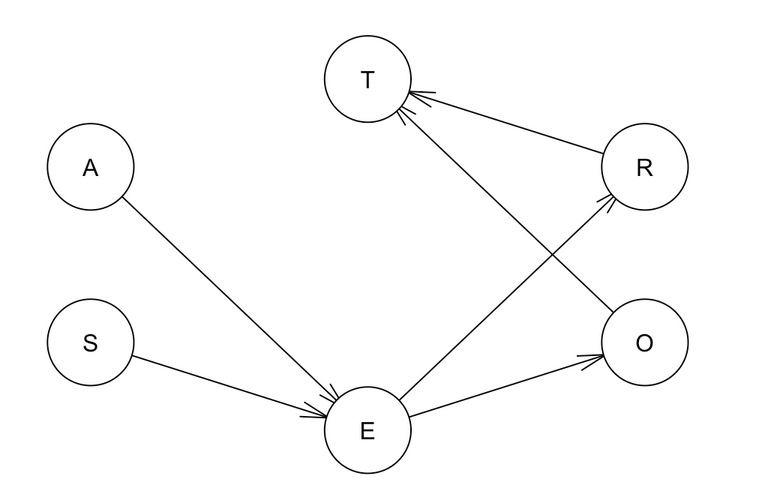</div>

[https://bookdown.org/robertness/causalml/docs/tutorial-probabilistic-modeling-with-bayesian-networks-and-bnlearn.html](https://bookdown.org/robertness/causalml/docs/tutorial-probabilistic-modeling-with-bayesian-networks-and-bnlearn.html)

We can represent the relationships between the variables in the survey data by a DAG, which represents a factorization of the *joint probability distribution* of this dataset: 

$$P(A,S,E,O,R,T)=P(A)P(S)P(E|A,S)P(O|E)P(R|E)P(T|O,R).$$

It is trivial to notice that $R\perp \!\!\! \perp O|E$ and that $R \not\!\perp \!\!\!\perp O|T$.

In fact, $P(R,O,E)=P(R|E)P(O|E)P(E)$ implies 

$$P(R,O|E)=P(R|E)P(O|E),$$

while $P(R,O,T)=P(R)P(O)P(T|R,O)$ and $P(T|R,O)\neq P(T)$, so 

$$P(R,O|T)\neq P(R)P(O).$$

### Bayesian Network from Gaussian Mixture

It may happen that the data that we are trying to model presents a complex structure, where multiple regions of the space have a high probability mass (the data has a **multimodal** distribution).

A **mixture model** is a particular hierarchical model made up by several components, each one with a simple parametric form. It assumes the data is clustered and that each data point is drawn from a distribution representing the assigned cluster. In a Bayesian setting, the mixture weights and parameters are random variables and the posterior is a conditional distribution over clusterings and parameters. 

In the case of **Gaussian mixtures**, the underlying components are modeled by Gaussians priors:

$$
p(x) = \sum_{k=1}^K \pi_k \mathcal{N}(\mu_k,\sigma_k^2)
$$

where $0 \leq \pi_k\leq 1$ and $\sum_{k=1}^K \pi_k = 1$.

<div> 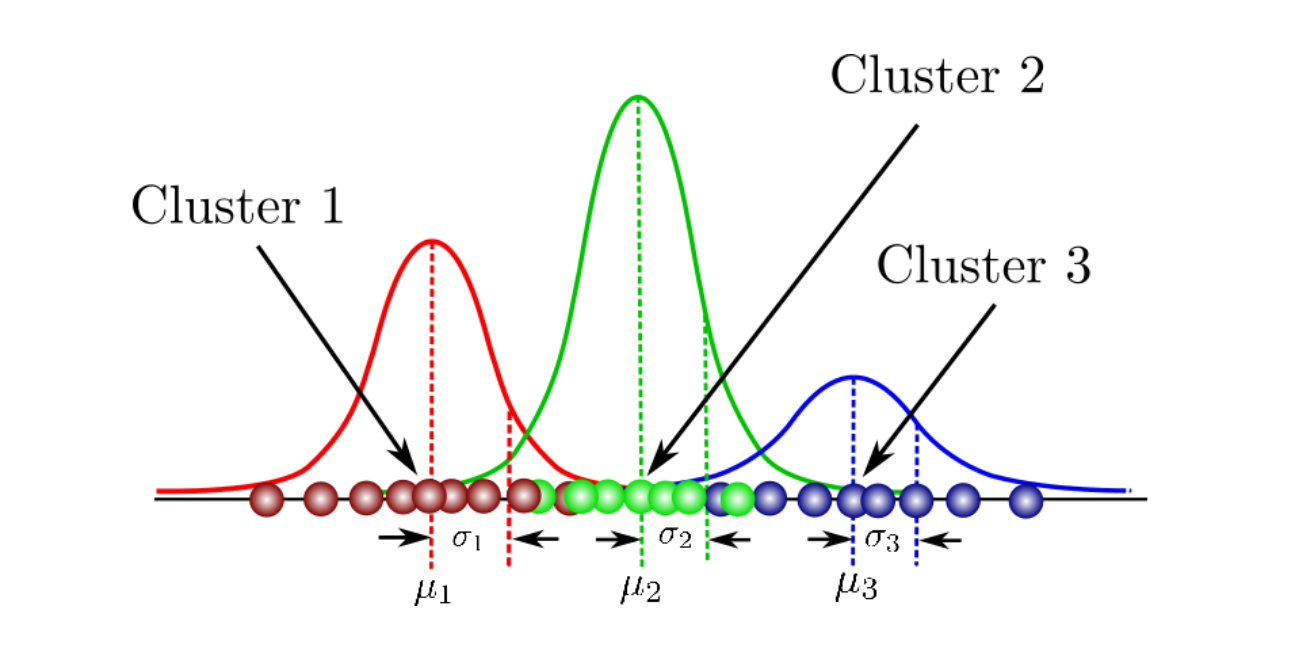</div>

[https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95](https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95)

In this section we consider a Gaussian mixture model taken from [Blei, "Build, Compute, Critique, Repeat:Data Analysis with Latent Variable Models"](http://www.cs.columbia.edu/~blei/papers/Blei2014b.pdf),
with the aim of showing that graphical models represent a powerful way to describe how the hidden structure of a model interacts with the observations.

The generative process is:
- $\theta \sim Dirichlet(\alpha)$
- $\mu_k \sim \mathcal{N}(0,\sigma_0^2)
$ for the mixture components
- for each data point $i$:
 - $z_i | \theta \sim Categorical(\theta)$
 - $x_i|z_i,\mu_{z_i} \sim \mathcal{N}(\mu_{z_i},1)$


<div> 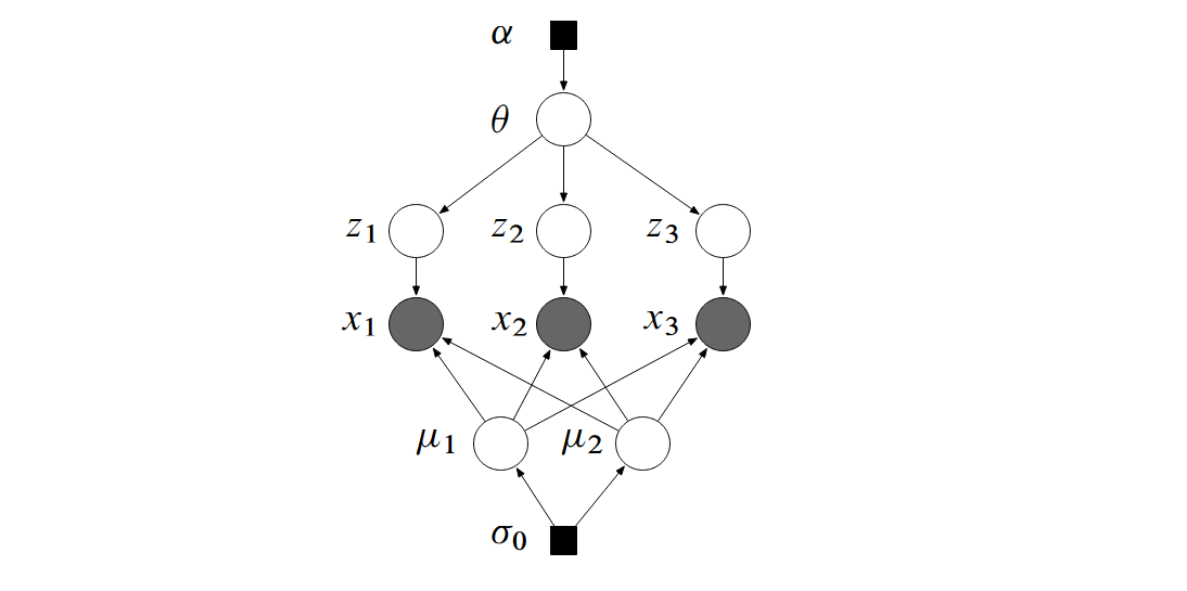</div>

[http://www.cs.columbia.edu/~blei/papers/Blei2014b.pdf](http://www.cs.columbia.edu/~blei/papers/Blei2014b.pdf)

where $\theta, \mu_k, z_i$ are the **hidden variables**, $x_i$ the **observables** and $\alpha, \sigma_0$ the fixed **hyperparameters**. The joint distribution factorizes as
$$p(\theta,\mu,z,x|\sigma_0,\alpha) = p(\theta|\alpha)\prod_{k=1}^K p(\mu_k|\sigma_0)\prod_{i=1}^N[p(z_i|\theta)p(x_i|z_i,\mu_k)].$$

From this representation the identification of *global* and *local* variables comes easy:
the first ones describe the hidden structure (which is shared for the entire dataset) and the latter ones only regard the distribution of single observations.

The posterior distribution, given the observations, is

$$p(\theta,\mu,z|x,\sigma_0,\alpha)=\frac{p(\theta,\mu,z,x|\sigma_0,\alpha)}{p(x|\sigma_0,\alpha)}.$$


**Pyro implementation**

In [143]:
import pyro
import torch
import pyro.distributions as dist

# observed data
data = torch.tensor([0., 1., 10., 11., 12.])

Pytorch computations operate on multidimensional arrays called **tensors**. Pytorch provides a wide variety of optimized tensor routines which can be run both on CPU and GPU, such as slicing, indexing, math operations, linear algebra, reductions. 

In [105]:
# number of components
K = 2 

# hyperparameters
alpha = 0.5
sigma_0 = 10.0

def model(data):
    
    # Global variables
    theta = pyro.sample('theta', dist.Dirichlet(alpha * torch.ones(K)))
    
    with pyro.plate('components', K):
        mu = pyro.sample('mu', dist.Normal(0., sigma_0))
        
    with pyro.plate('data', len(data)):
        # Local variables
        z = pyro.sample('z', dist.Categorical(probs=theta))
        x = pyro.sample('x', dist.Normal(mu[z], 1), obs=data)
    
    print("theta =",theta,"\nmu =",mu,"\nz =", z,"\nx =",  x)
    
model(data=[7, 0.8, 0.1, 6, 0.5, 6.8])

theta = tensor([0.8985, 0.1015]) 
mu = tensor([ -3.3157, -12.3984]) 
z = tensor([0, 1, 1, 0, 0, 0]) 
x = [7, 0.8, 0.1, 6, 0.5, 6.8]


`pyro.plate()` method guarantees that all computations within a `plate` are **conditionally independent**

```
with pyro.plate("tensor name", tensor size):
    # ...do conditionally independent stuff ...
```

## Markov Random Fields

A Markov random field is an undirected graphical model, whose **nodes** correspond to variables and whose **edges** represent conditional dependences between variables.

Any two nodes that are not connected by a direct edge (not adjacent) are **conditionally independent** given all the other nodes in the graph. 

<div> 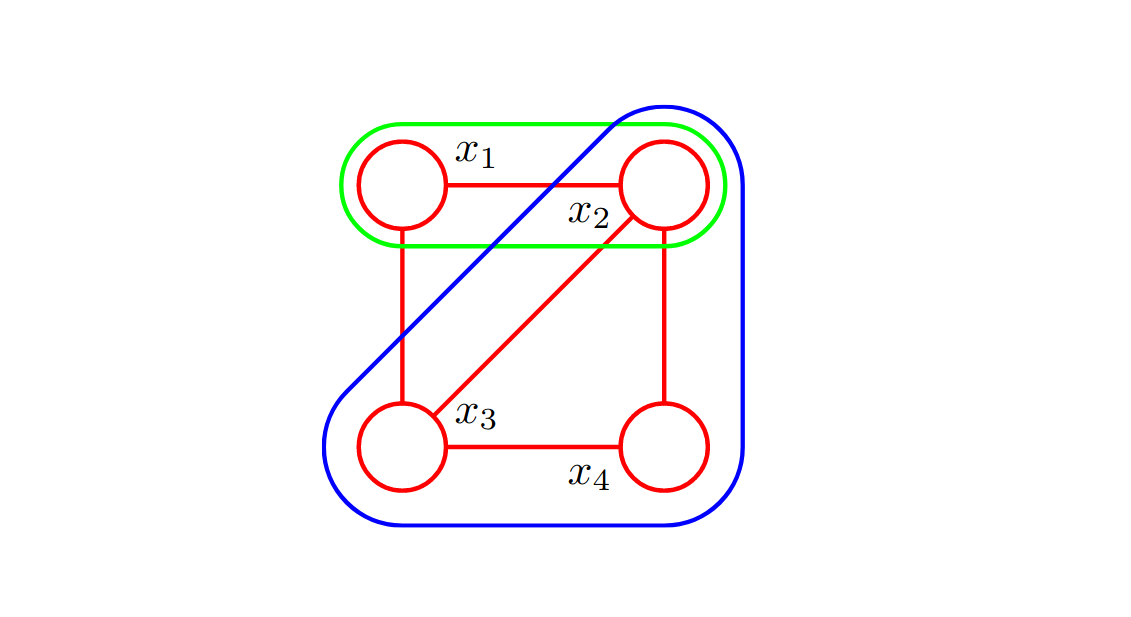</div>
<div style="color:darkblue">C. M. Bishop, "Pattern Recognition and Machine Learning"</div>

The factorization rule for undirected graphs is based on the notion of **cliques**, which are fully connected subgraphs of the original graph.
The joint distribution factorizes as the product of *potential functions* 

$$\psi_C(x_C)=e^{-E(X_C)}$$

of an *energy* fucntion $E$ over the maximal cliques of the graph 

$$p(x)=\frac{1}{Z}\prod_C \psi_C(x_C).$$



### Ising model for binary image denoising 

MRF applications in computer vision include image segmentation, image completion and image denoising. In all such cases they are used to impose smoothness constraints on the neighboring pixels.

The **Ising model** assumes that we have a grid of nodes, where each node can be in one of two states. In the case of binary images, you can think of each node as being a pixel with a black or white color.
The state of each node depends on the neighboring nodes through interaction potentials, which impose the smoothness constraint over pixels.

In an **image denoising** problem, we assume that we have a 2D grid of noisy pixel observations of an underlying true image and we would like to recover the true image. Suppose that $x_i$ is a binary variable denoting the state of pixel $i$ in the unknown original image, while $y_i$ represents the corresponding state in the observed noisy image.

<div> 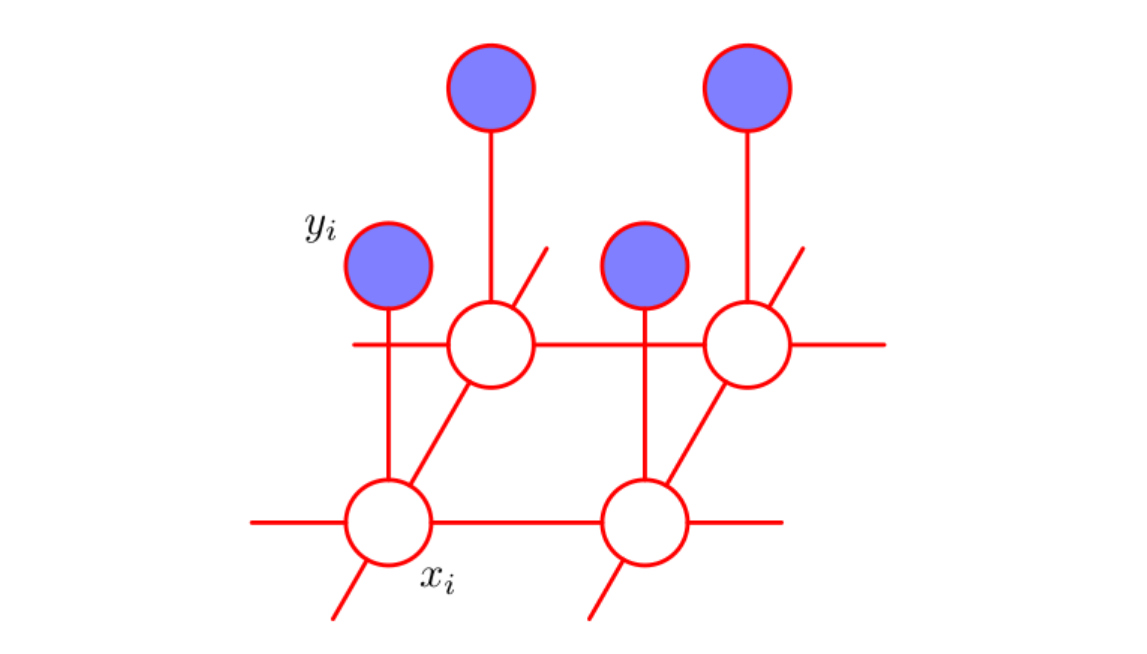</div>
<div style="color:darkblue">C. M. Bishop, "Pattern Recognition and Machine Learning"</div>

**energy**

**ICM**


In [163]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

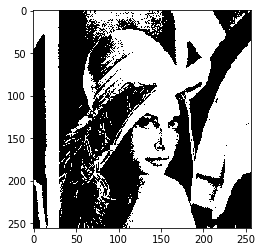

In [162]:
im = mpimg.imread('data/lena.png')[:,:,0]
im = np.where(im>0.5,-1,1)
plt.imshow(im, cmap = cm.Greys)

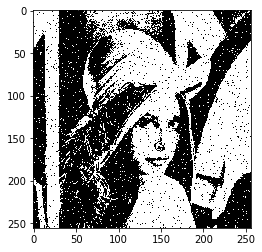

In [160]:
noise = np.zeros((im.shape))

with pyro.plate('pixels', 256*256):
    noise = pyro.sample('mu', dist.Normal(0., 0.5)).reshape(256,256)
    
noisy = np.where(noise+1<0.1,-1,1)
noisy_im = im*noisy
plt.imshow(noisy_im, cmap = cm.Greys)

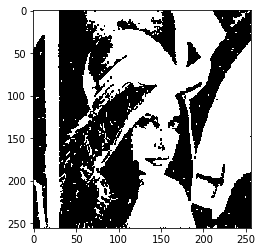

In [165]:
h = 0.5
beta = 1.0
eta = 2.1

# ICM
noisy_im_old = noisy_im
for iter in range(0,3):
    for i in range(0,255):
        for y in range(0,255):
            # three factors 
            factor_three = 0 # cliques that represent pairs between 
                             #latent variables (neighbours)
            factor_two = 0 # energy function for the cliques between 
                           # latent and observed values
            factor_one = 0 # bias
            x_i = 1
            y_i = noisy_im_old[i][y]
            # noisy_im[][] are the x_j neighbours 
            if i-1 >= 0:
                factor_three += noisy_im[i-1][y]*x_i
            if i+1 < 512:
                factor_three += noisy_im[i+1][y]*x_i
            if y-1 >= 0:
                factor_three += noisy_im[i][y-1]*x_i
            if y+1 < 512:
                factor_three += noisy_im[i][y+1]*x_i
            factor_two = x_i*y_i
            factor_one = x_i
            #print(factor_one, factor_two, factor_three)
            one = h*factor_one - beta*factor_three - eta*factor_two
            factor_one = 0
            factor_three = 0
            factor_two = 0
            x_i = -1
            if i-1 >= 0:
                factor_three += noisy_im[i-1][y]*x_i
            if i < 256:
                factor_three += noisy_im[i+1][y]*x_i
            if y-1 >= 0:
                factor_three += noisy_im[i][y-1]*x_i
            if y < 256:
                factor_three += noisy_im[i][y+1]*x_i
            factor_two = x_i*y_i
            factor_one = x_i
            minus_one =  h*factor_one - beta*factor_three - eta*factor_two
            #print(one, minus_one)
            if np.any(one < minus_one):
                noisy_im[i][y] = 1
            else:
                noisy_im[i][y] = -1
    noisy_im_old = noisy_im

imgplot = plt.imshow(noisy_im_old, cmap = cm.Greys)
plt.show()

## References
- [R. Ness "Lecture Notes for Causality in Machine Learning"](https://bookdown.org/robertness/causalml/docs/)
- [D. Blei, "Build, Compute, Critique, Repeat:Data Analysis with Latent Variable Models"](http://www.cs.columbia.edu/~blei/papers/Blei2014b.pdf)
- [R. Grosse, N. Srivastava, "Mixture models"](http://www.cs.toronto.edu/~rgrosse/csc321/mixture_models.pdf)
- C. M. Bishop, "Pattern Recognition and Machine Learning"